# Scattering

## 1. Morlet Wavelet

In [1]:
%matplotlib inline
%load_ext line_profiler
from mnist import MNIST
import numpy as np
from scipy import signal, misc, ndimage
from itertools import combinations
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.decomposition import PCA



In [2]:
def Morlet2D_grid(n_lines, n_columns, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """returns 2d Morlet real and imaginary filter of size (n_lines, n_columns), rotated by theta and dilated by 1/2^J"""
    X = np.arange(-n_columns / 2**(J+1), n_columns / 2**(J+1), 1/2**J) #to get n_columns length vector
    Y = np.arange(-n_lines / 2**(J+1), n_lines / 2**(J+1), 1/2**J)
    X, Y = np.meshgrid(X, Y)
    #rotate
    X_theta = np.cos(theta) * X + np.sin(theta) * Y 
    Y_theta = np.cos(theta) * Y - np.sin(theta) * X
    
    Wave = np.exp(1j * xi * (X_theta + Y_theta))
    Z_r = np.real(Wave)
    Z_i = np.imag(Wave)
    Gaus = np.exp(-np.sqrt(X_theta**2 + Y_theta**2) / (2 * sigma**2))
    Z_r *= Gaus
    Z_i *= Gaus
    
    #center Morlet wave
    Int_r = np.sum(Z_r)
    Int_i = np.sum(Z_i)
    Int_Gaus = np.sum(Gaus)

    beta_r = Int_r / Int_Gaus
    beta_i = Int_i/ Int_Gaus
    
    Z_r -= beta_r * Gaus
    Z_i -= beta_i * Gaus
    return(Z_r + 1j * Z_i)

### Representation d'une ondelette Morlet

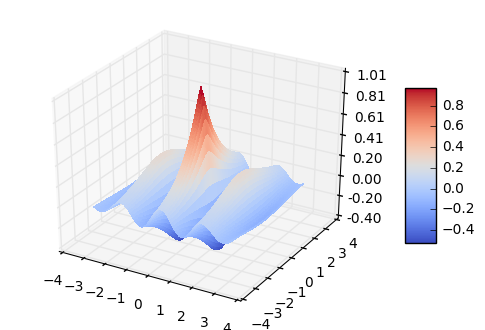

In [3]:
Z = Morlet2D_grid(100, 100, 4, theta = 3*np.pi/4)
Z_r = np.real(Z)
Z_i = np.imag(Z)
X = np.arange(-100 / 32, 100 / 32, 1/16)
Y = np.arange(-100 / 32, 100 / 32, 1/16)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z_r, rstride=1, cstride=1, cmap = cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_zlim(-0.4, 1.01)


ax.zaxis.set_major_locator(LinearLocator(8))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Convolution 

In [9]:
def morl_conv(image, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """image of shape (n_lines, n_columns) (levels of grey not RGB), returns convolution with Morlet2D_grid"""
    morlet_filter = Morlet2D_grid(image.shape[0], image.shape[1], J, theta, sigma, xi)
    return (signal.fftconvolve(image, morlet_filter, mode = "same"))

In [5]:
mndata = MNIST('/home/sel/Desktop/cours ENSAE/TensorFlow/MNIST-data')

In [6]:
mnist_images = mndata.load_training()


In [10]:
train_set = []
label_set = []
sample_size = 400
for i in range(sample_size):
    train_set.append(np.array(mnist_images[0][i]).reshape(28,28))
    label_set.append(mnist_images[1][i])

In [11]:
f = np.array(mnist_images[0][0]).reshape(28,28)
print(mnist_images[1][0])

5


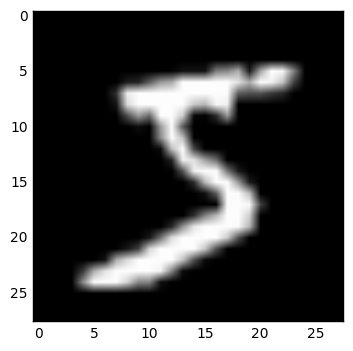

In [12]:
plt.imshow(f, cmap=plt.cm.gray)

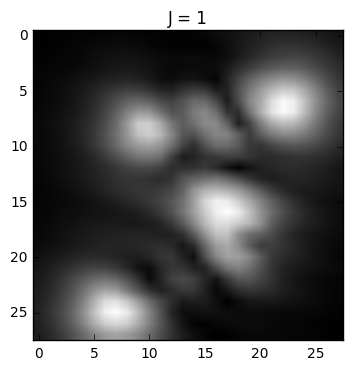

In [16]:
fig = plt.figure()
a = fig.add_subplot(1, 1, 1)
f2 = morl_conv(f, J = 1, theta = np.pi/3)
f2 = np.abs(f2)
plt.imshow(f2, cmap = plt.cm.gray)
a.set_title("J = 1")

[  7.25956134   8.50109857  10.00706918  12.0037777   14.17125736
  16.5058663   18.16777183  18.97891281  18.26087365  16.06304955
  13.14281309  10.70063582   9.4613434   10.1226116   12.99229792
  18.54317726  27.41236509  38.5160251   50.33053173  61.44265063
  70.6263233   76.8722604   79.56647731  78.60949373  73.71806257
  65.60040574  55.67625176  46.58322656]
[  6.98632416   8.31452061   9.65614569  11.53983694  13.477827
  15.70144849  17.14592149  17.91760417  17.19277165  15.07382414
  12.31469207  10.14739195   9.03542964   9.83793953  13.22952989
  19.53178043  28.44947651  39.0850672   50.20298843  60.53415933
  68.9564105   74.53323112  76.72016234  75.61940687  70.79457986
  62.94666767  53.4160221   43.83147559]


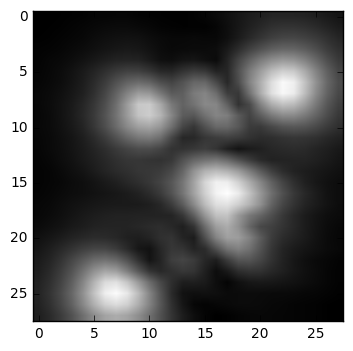

In [14]:
f3 = ndimage.filters.gaussian_filter(f2, 1/2)
plt.imshow(f3, cmap = plt.cm.gray)
print(f3[0, :])
print(f2[0, :])

## Computing Scattering coeffs

In [17]:
def cascade_wavelet_transf(image, j_path, theta_path):
    """js_path is the dilatations 2**-j we want to compute, thetas_path is similarly thetas path for the rotations 
    returns U[p]: see Mallat article """
    U = image.copy()
    for j, theta in zip(j_path, theta_path):
        U = np.abs(morl_conv(U, J = j, theta = theta))
    return U
        
            

In [18]:
def scattering_paths(J, m, K):
    """ returns a list of all paths = [(j_path, theta_path)] of length M with j_path[k]<j_path[k+1]<= J
        and theta = 2 * np.pi * k, k < K"""
    thetas = [2 * np.pi * k / K for k in range(K)]
    js_path = [list(comb) for comb in combinations(range(1, J + 1), m)]
    thetas_paths = [[theta] for theta in thetas]
    scat_path = []
    for i in range(m - 1):
        new_th_paths = []
        for j in range(len(thetas_paths)):
            for theta in thetas:
                new_th_paths.append(thetas_paths[j] + [theta])
        thetas_paths = new_th_paths
    for j_path in js_path:
        for th_path in thetas_paths:
            scat_path.append((j_path, th_path))
    return scat_path

In [19]:
def scatter_coeffs_long(image, m, K, J = 0, alpha = 1/2):
    
    """J = number of dilatations, m = length of the scattering conv network, K = number of rotations
    too long"""
    if J == 0:
        J = int(math.log(image.shape[0], 2))
    print(J)
    scat_coeffs = {}
    for i in range(1, m + 1):
        scat_coeffs[i] = []
        for path in scattering_paths(J, i, K):
            U_path = cascade_wavelet_transf(image, path[0], path[1])
            S_U_path = 1/2**J*ndimage.filters.gaussian_filter(U_path, 1/2**J)
            scat_coeffs[i].append(S_U_path) #vérifier que c'est toujous les mêmes
    print(len(scat_coeffs[1]), len(scat_coeffs[2]))
    return scat_coeffs
            

In [20]:
def continue_path(path, J, K):
    """gets a scattering path of length m, outputs a list of all paths of length m+1 that you could obtain from this path"""
    cont_paths = []
    
    if type(path[0]) == int:#du au fait qu'un tuple ne peut pas avoir une longueur de 1
        j_m = path[0]
    else:
        j_m = path[-1][0]
    thetas = [2 * np.pi * k / K for k in range(K)]
    for j in range(j_m + 1, J + 1):
        for theta in thetas:
            if type(path[0]) == int:
                path1 = [path]
            else:
                path1 = list(path)
            path1 += [(j, theta)]
            cont_paths.append(tuple(path1))
    return cont_paths

continue_path(((1,2),(2, 3*np.pi)), 5, 3)

[((1, 2), (2, 9.42477796076938), (3, 0.0)),
 ((1, 2), (2, 9.42477796076938), (3, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (3, 4.1887902047863905)),
 ((1, 2), (2, 9.42477796076938), (4, 0.0)),
 ((1, 2), (2, 9.42477796076938), (4, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (4, 4.1887902047863905)),
 ((1, 2), (2, 9.42477796076938), (5, 0.0)),
 ((1, 2), (2, 9.42477796076938), (5, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (5, 4.1887902047863905))]

In [21]:
def scatter_coeffs_fast(image, m, K, J = 0, alpha = 1/2):
    """J = number of dilatations, m = length of the scattering conv network, K = number of rotations"""
    if J == 0 :
        J = int(math.log(image.shape[0], 2))
    scat_coeffs = []
    paths = []
    U_p = {1 : {}}
    for j in range(1, J +1):
        for theta in [2 * np.pi * k / K for k in range(K)]:
            path = (j, theta)
            paths.append((path))
            U_p[1][path] = np.abs(morl_conv(image, J = path[0], theta = path[1]))
    for i in range(1, m):
        U_p[i+1] = {}
        paths2 = []
        for path in paths:
            scat_coeffs.append(1/2**J*ndimage.filters.gaussian_filter(U_p[i][path], 1/2**J))
            for next_path in continue_path(path, J, K):
                U_p[i+1][next_path] =  np.abs(morl_conv(image, J = next_path[-1][0], theta = next_path[-1][0]))
                paths2.append(next_path)
        paths = paths2
    for path in paths:
        scat_coeffs.append(1/2**J*ndimage.filters.gaussian_filter(U_p[m][path], 1/2**J))
    return scat_coeffs

In [18]:
%lprun -f morl_conv scatter_coeffs_long(f, 2, 6)

4
24 216


In [22]:
%lprun -f morl_conv scatter_coeffs_fast(f, 2, 6)

In [23]:
Scatter_data = []
for i in range(len(train_set)):
    if i%100 == 0:
        print(i)
    Scatter_data.append(scatter_coeffs_fast(train_set[i], 2, 6))

0
100
200
300


In [23]:
len(Scatter_data[0])

240

In [24]:
sc_data = {i: [] for i in range(10)}

In [25]:
for i in range(len(Scatter_data)):
    sc_data[label_set[i]].append(Scatter_data[i])

In [26]:
for i in range(10):
    print(len(sc_data[i]))
for i in range(10):
    for j in range(len(sc_data[i])):
        final_coeff = np.zeros(1)
        for coeff in sc_data[i][j]:
            final_coeff = np.concatenate((final_coeff, coeff.reshape(784)))
        sc_data[i][j] = final_coeff[1:]
print(sc_data[3][0].shape, type((sc_data[1][0][0])))

39
52
42
41
44
30
36
42
30
44
(188160,) <class 'numpy.float64'>


In [27]:
print(sc_data[5][0].shape, type((sc_data[1][0][0])))

(188160,) <class 'numpy.float64'>


In [31]:
del Scatter_data

In [56]:
pca = PCA(n_components=5)

In [57]:
zero_new = pca.fit_transform(np.array(sc_data[0]))

In [29]:
pcas = {}
for i in range(5):
    print(i)
    pcas[i] = PCA(n_components = 5)
    pcas[i].fit(sc_data[i])

0
1
2
3
4


In [52]:
predictions = {i : [0,0] for i in range(5)}

for j in range(100):
    label = mnist_images[1][400 + j]
    if label < 5:
        predictions[label][1] +=1
        print(j)
        coeffs = scatter_coeffs_fast(np.array(mnist_images[0][400 + i]).reshape((28,28)), 2, 6)
        final_coeff = np.zeros(1)
        for coeff in coeffs:
            final_coeff = np.concatenate((final_coeff, coeff.reshape(784)))
        final_coeff = final_coeff[1:]
        final_coeff.reshape(-1, 1)
        pred_label = 0
        proj = np.linalg.norm(pcas[0].transform(final_coeff))
        for i in range(0, 5):
            pot_proj = np.linalg.norm(pcas[i].transform(final_coeff))
            print("valeur de la projection sur {} est de {}".format(i, pot_proj))
            if pot_proj < proj:
                proj = pot_proj
                pred_label = i
        if pred_label == label:
            predictions[label][0] += 1
        print("n° {} ".format(j), " vraie valeur : {}".format(label), " valeur prédite : {} ".format(pred_label))
        

0


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 0   vraie valeur : 2  valeur prédite : 3 
2


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 2   vraie valeur : 4  valeur prédite : 3 
5


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 5   vraie valeur : 3  valeur prédite : 3 
6


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 6   vraie valeur : 1  valeur prédite : 3 
8


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 8   vraie valeur : 1  valeur prédite : 3 
10


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 10   vraie valeur : 2  valeur prédite : 3 
12


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 12   vraie valeur : 4  valeur prédite : 3 
13


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 13   vraie valeur : 4  valeur prédite : 3 
14


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 14   vraie valeur : 4  valeur prédite : 3 
16


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 16   vraie valeur : 1  valeur prédite : 3 
25


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 25   vraie valeur : 3  valeur prédite : 3 
27


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 27   vraie valeur : 0  valeur prédite : 3 
29


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 29   vraie valeur : 0  valeur prédite : 3 
32


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 32   vraie valeur : 2  valeur prédite : 3 
33


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 33   vraie valeur : 3  valeur prédite : 3 
35


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 35   vraie valeur : 0  valeur prédite : 3 
38


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 38   vraie valeur : 4  valeur prédite : 3 
40


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 40   vraie valeur : 0  valeur prédite : 3 
42


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 42   vraie valeur : 4  valeur prédite : 3 
43


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 43   vraie valeur : 1  valeur prédite : 3 
44


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 44   vraie valeur : 2  valeur prédite : 3 
47


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 47   vraie valeur : 1  valeur prédite : 3 
48


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 48   vraie valeur : 2  valeur prédite : 3 
50


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 50   vraie valeur : 1  valeur prédite : 3 
51


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 51   vraie valeur : 0  valeur prédite : 3 
52


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 52   vraie valeur : 3  valeur prédite : 3 
53


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 53   vraie valeur : 0  valeur prédite : 3 
54


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 54   vraie valeur : 1  valeur prédite : 3 
55


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 55   vraie valeur : 1  valeur prédite : 3 
57


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 57   vraie valeur : 2  valeur prédite : 3 
58


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 58   vraie valeur : 0  valeur prédite : 3 
59


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 59   vraie valeur : 3  valeur prédite : 3 
61


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 61   vraie valeur : 4  valeur prédite : 3 
62


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 62   vraie valeur : 0  valeur prédite : 3 
64


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 64   vraie valeur : 0  valeur prédite : 3 
66


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 66   vraie valeur : 1  valeur prédite : 3 
70


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 70   vraie valeur : 1  valeur prédite : 3 
72


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 72   vraie valeur : 2  valeur prédite : 3 
73


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 73   vraie valeur : 0  valeur prédite : 3 
75


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 75   vraie valeur : 1  valeur prédite : 3 
76


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 76   vraie valeur : 2  valeur prédite : 3 
77


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 77   vraie valeur : 2  valeur prédite : 3 
79


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 79   vraie valeur : 3  valeur prédite : 3 
81


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 81   vraie valeur : 4  valeur prédite : 3 
84


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 84   vraie valeur : 1  valeur prédite : 3 
86


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 86   vraie valeur : 3  valeur prédite : 3 
89


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 89   vraie valeur : 0  valeur prédite : 3 
90


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 90   vraie valeur : 3  valeur prédite : 3 
91


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 91   vraie valeur : 1  valeur prédite : 3 
92


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 92   vraie valeur : 1  valeur prédite : 3 
93


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 93   vraie valeur : 2  valeur prédite : 3 
95
valeur de la projection sur 0 est de 29480.64993653544
valeur de la projection sur 1 est de 55303.21431813689
valeur de la projection sur 2 est de 38384.50917494377
valeur de la projection sur 3 est de 25189.199303899037
valeur de la projection sur 4 est de 31981.45060675521
n° 95   vraie valeur : 3  valeur prédite : 3 


/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sel/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

In [53]:
for i in range(5):
    print(predictions[i][0], predictions[i][1])

0 11
0 14
0 10
9 9
0 8
